<a href="https://colab.research.google.com/github/Dp20032/Neuromatch_BrainCancer/blob/Dhiren/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchsummary import summary

import os
from google.colab import files
from PIL import Image
import subprocess

In [2]:
# @title Data Loading
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
 95% 141M/149M [00:00<00:00, 187MB/s]
100% 149M/149M [00:00<00:00, 182MB/s]


In [3]:
# @title Download and processing Zenodo data - unneeded, data represented in original dataset
#!wget https://zenodo.org/record/7047164/files/adnoma.zip
#!wget https://zenodo.org/record/7047164/files/Gliomas.zip
#!wget https://zenodo.org/record/7047164/files/Meningioma.zip

def grab_format_zenodo(type='adnoma', size=(256,256)):
  url = f'https://zenodo.org/record/7047164/files/{type}.zip'
  print(f'Downloading {type}')
  subprocess.call(['wget', '-v', url])
  print(f'{type} acquired, unzipping...')
  subprocess.call(['unzip', '-q', f'{type}.zip'])
  files = os.listdir(f'./{type}')
  print(f'Unzipping {type} completed [{len(files)} samples extracted], beginning conversion...')
  size=(256,256)
  for i in files:
    im = Image.open(f'./{type}/{i}')
    i, _ = i.split('.')
    new = im.resize(size)
    if not os.path.isdir(f'./{type}_png'):
      os.mkdir(f'./{type}_png')
    new.save(f'./{type}_png/{i}.png', 'png')

# for i in ['adnoma', 'Gliomas', 'Meningioma']:
#   grab_format_zenodo(type=i)


In [4]:
classes = os.listdir('./Training/')

0 tensor([1, 3, 3, 1, 0, 1, 2, 3, 1, 2])


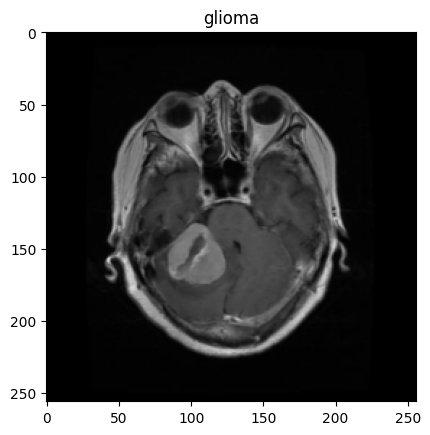

In [5]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])
import matplotlib.pyplot as plt
TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=10, shuffle=True)
for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [9]:
device= device = torch.device("cuda")

Epoch 1, Batch 50, Loss: 1.612
Epoch 1, Batch 100, Loss: 1.277
Epoch 1, Batch 150, Loss: 1.064
Epoch 1, Batch 200, Loss: 1.209
Epoch 1, Batch 250, Loss: 0.807
Epoch 1, Batch 300, Loss: 0.947
Epoch 1, Batch 350, Loss: 1.202
Epoch 1, Batch 400, Loss: 0.781
Epoch 1, Batch 450, Loss: 0.709
Epoch 1, Batch 500, Loss: 0.814
Epoch 1, Batch 550, Loss: 0.748
Epoch 1 Loss: 0.996
Epoch 2, Batch 50, Loss: 0.872
Epoch 2, Batch 100, Loss: 0.907
Epoch 2, Batch 150, Loss: 0.727
Epoch 2, Batch 200, Loss: 0.621
Epoch 2, Batch 250, Loss: 0.803
Epoch 2, Batch 300, Loss: 0.709
Epoch 2, Batch 350, Loss: 1.104
Epoch 2, Batch 400, Loss: 0.696
Epoch 2, Batch 450, Loss: 0.534
Epoch 2, Batch 500, Loss: 0.601
Epoch 2, Batch 550, Loss: 0.738
Epoch 2 Loss: 0.758
Finished Training
Finished Training


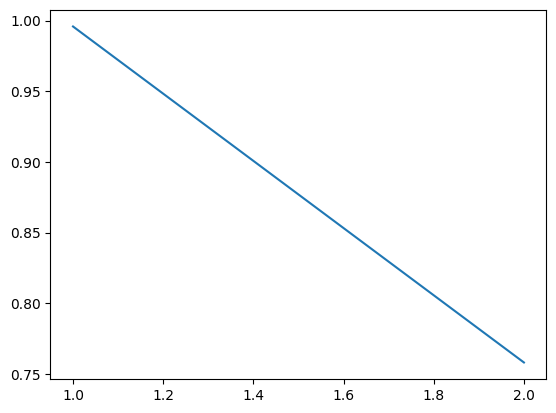

In [18]:
Classifier = models.vgg19(weights='DEFAULT')

for param in Classifier.features.parameters():
    param.requires_grad = False


#Replace the classifying linear network with one with custom number of output classes
num_features = Classifier.classifier[-1].in_features
Classifier.classifier[-1] = nn.Linear(num_features, 4)

Classifier = Classifier.to(device)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Classifier.parameters(), lr=0.001)


num_epochs = 2
epoch_loss=[]

for epoch in range(num_epochs):
    running_loss = 0.0
    mini_batch_loss= 0.0
    for batch_number, (images, labels) in enumerate(TrainingLoader):

       images = images.to(device)
       labels = labels.to(device)

       optimizer.zero_grad()
       outputs = Classifier(images)
       loss = loss_function(outputs, labels)

       loss.backward()
       optimizer.step()

       running_loss += loss.item()
       mini_batch_loss += loss.item()

       if (batch_number + 1) % 50 == 0:
          print(f'Epoch {epoch + 1}, Batch {batch_number + 1}, Loss: {mini_batch_loss / 50:.3f}')
          mini_batch_loss = 0.0

    epoch_loss.append(running_loss / len(TrainingLoader))
    print(f'Epoch {epoch + 1} Loss: {running_loss / len(TrainingLoader):.3f}')

print('Finished Training')


print('Finished Training')
plt.plot(range(1,num_epochs+1,1), epoch_loss)